# NASLib : Exploring the search spaces

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from monet.utils.helpers import configure_seaborn
import seaborn as sns
configure_seaborn()
from naslib.utils import get_dataset_api
from naslib.search_spaces.core.query_metrics import Metric
from tqdm import tqdm

## NAS-Bench-201
Let's all begin with our favorite search space, NAS-Bench-201.

In [2]:
from naslib.search_spaces import nasbench201 as nb201

Plot all architectures

In [3]:
from nas_201_api import NASBench201API

In [4]:
dataset_api = get_dataset_api("nasbench201", 'cifar10')
real_nb201_api = NASBench201API("../naslib/data/NAS-Bench-201-v1_0-e61699.pth", verbose=False)

In [5]:
from xautodl.models import get_cell_based_tiny_net
from naslib.search_spaces.nasbench201.conversions import convert_str_to_op_indices, convert_op_indices_to_naslib
params = []
accuracies = []

for i, arch_str in tqdm(enumerate(real_nb201_api)):
    indices = convert_str_to_op_indices(arch_str)
    objec = nb201.graph.NasBench201SearchSpace()
    convert_op_indices_to_naslib(indices, objec)
    naslib_results = objec.query(dataset='cifar10', metric=Metric.VAL_ACCURACY, dataset_api=dataset_api)
    id = real_nb201_api.query_index_by_arch(arch_str)
    info = real_nb201_api.query_meta_info_by_index(id, hp="200")
    nb_results = info.get_metrics("cifar10-valid", "x-valid")["accuracy"]
    config = real_nb201_api.get_net_config(id, 'cifar10-valid')  # obtain the network configuration for the n-th architecture on the CIFAR-10 dataset
    network = get_cell_based_tiny_net(config)  # create the network from configuration
    n_params = sum([np.prod(p.size()) for p in network.parameters()])
    params.append(n_params)
    accuracies.append(nb_results)


50it [00:06,  7.70it/s]


KeyboardInterrupt: 

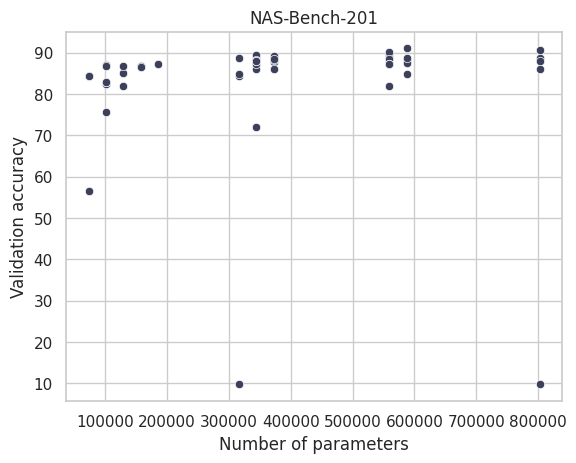

In [6]:
sns.scatterplot(x=params, y=accuracies)
plt.xlabel("Number of parameters")
plt.ylabel("Validation accuracy")
plt.title("NAS-Bench-201")
plt.show()

In [7]:
from naslib.optimizers.discrete.re.optimizer import RegularizedEvolution

In [8]:
from yacs.config import CfgNode

config = CfgNode()
config.dataset = 'cifar10'
config.search = CfgNode()
config.search.epochs = 10
config.search.sample_size = 10
config.search.population_size = 10
re = RegularizedEvolution(config)

In [9]:
re.adapt_search_space(nb201.graph.NasBench201SearchSpace())
re.dataset_api = dataset_api

In [11]:
from naslib.search_spaces.nasbench201.conversions import convert_naslib_to_str

# Run regularized evolution
for epoch in tqdm(range(100)):
    re.new_epoch(epoch)
# Print best architecture
str = convert_naslib_to_str(re.get_final_architecture())
print(str)
print(re.get_final_architecture().query(dataset='cifar10', metric=Metric.VAL_ACCURACY, dataset_api=dataset_api))

100%|██████████| 100/100 [00:13<00:00,  7.16it/s]

|nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_1x1~1|nor_conv_3x3~2|
91.57


In [12]:
for h in re.history:
    print(h.arch.query(dataset='cifar10', metric=Metric.VAL_ACCURACY, dataset_api=dataset_api))

91.57
91.33
91.32
91.27
91.15
90.75
90.21
89.99
89.99
89.75
86.29
89.62
89.62
90.13
88.7
89.0
89.2
88.59
88.88
87.55
90.13
88.56
89.25
88.56
90.24
89.0
89.39
89.5
88.61
89.65
89.65
88.49
90.39
89.96
87.56
89.09
89.31
89.28
88.49
90.23
90.23
88.85
89.1
86.11
87.26
78.23
90.21
89.39
86.22
82.06
88.34
88.33
88.02
83.84
88.03
87.82
88.98
88.95
87.58
71.42
88.88
86.17
89.16
89.54
87.31
89.71
89.41
88.24
89.32
90.01
88.9
89.12
89.71
88.71
89.12
88.71
89.18
87.65
88.71
87.84
89.09
87.7
87.84
88.75
89.76
89.75
90.04
88.81
89.35
88.91
89.78
89.13
89.15
89.17
88.17
88.73
88.91
89.03
88.88
88.01


## NAS-Bench-101
Let's all continue with NAS-Bench-101.

In [2]:
from naslib.search_spaces import nasbench101 as nb101

In [3]:
from nasbench import api

2024-11-26 17:42:09.240391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 17:42:09.487472: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 17:42:10.375680: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-11-26 17:42:10.375810: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

In [4]:
# Iterate over all possible architectures in Nas-Bench-101 using api
# nasbench101_api = api.NASBench('../naslib/data/nasbench_full.tfrecord')

In [18]:
from monet.search_spaces import nasbench101_node
from monet.node import Node
from naslib.search_spaces.core import Metric
import numpy as np
import importlib
importlib.reload(nasbench101_node)
from monet.search_spaces.nasbench101_node import NASBench101Cell

node = Node(NASBench101Cell(7))
nb101_api = get_dataset_api("nasbench101", 'cifar10')["nb101_data"]
# Play random actions until cell completion
while not node.state.is_complete():
    actions = node.state.get_action_tuples()
    action = actions[np.random.randint(len(actions))]
    print(action)
    node.play_action(action)
s = node.get_reward(nb101_api, metric=Metric.VAL_ACCURACY, dataset='cifar10')
print(s)

Loading dataset from file... This may take a few minutes...
Loaded dataset in 5 seconds
(4, 'set_label', 'conv1x1-bn-relu')
(6, 'build_edge', 2)
(4, 'build_edge', 3)
(3, 'build_edge', 2)
(6, 'build_edge', 0)
(2, 'set_label', 'conv3x3-bn-relu')
(2, 'build_edge', 0)
(6, 'build_edge', 3)
(6, 'build_edge', 1)
(5, 'set_label', 'maxpool3x3')
(3, 'set_label', 'conv1x1-bn-relu')
(1, 'set_label', 'conv3x3-bn-relu')
93.97035241127014


In [32]:
from monet.search_algorithms import mcts_agent
from yacs.config import CfgNode
importlib.reload(mcts_agent)
from monet.search_algorithms.mcts_agent import UCT

node = Node(NASBench101Cell(7))
config = CfgNode.load_cfg(open('../naslib/configs/uct.yaml'))
mcts = UCT(config)
mcts.adapt_search_space("nasbench101", "cifar10")

Reducing number of iterations
Loading dataset from file... This may take a few minutes...
Loaded dataset in 5 seconds


In [33]:
mcts.main_loop()

(5, 'set_label', 'conv1x1-bn-relu')
(2, 'set_label', 'conv3x3-bn-relu')
(4, 'set_label', 'maxpool3x3')
(4, 'build_edge', 0)
(5, 'build_edge', 4)
(3, 'set_label', 'conv3x3-bn-relu')
(3, 'build_edge', 1)
(6, 'build_edge', 3)
(3, 'build_edge', 0)
(1, 'set_label', 'conv3x3-bn-relu')


### Regularized Evolution

In [8]:
from naslib.optimizers.discrete.re.optimizer import RegularizedEvolution

In [30]:
from naslib.search_spaces import NasBench101SearchSpace

config = CfgNode()
config.dataset = 'cifar10'
config.search = CfgNode()
config.search.epochs = 1000
config.search.sample_size = 25
config.search.population_size = 100
api = get_dataset_api("nasbench101", 'cifar10')
# Run RE
re = RegularizedEvolution(config)
re.adapt_search_space(NasBench101SearchSpace())
re.dataset_api = api
# Run regularized evolution
for epoch in tqdm(range(config.search.epochs)):
    re.new_epoch(epoch)
final_reward = re.get_final_architecture().query(dataset='cifar10', metric=Metric.VAL_ACCURACY, dataset_api=api)
print(f"RE best reward : {final_reward}")

Loading dataset from file... This may take a few minutes...


KeyboardInterrupt: 

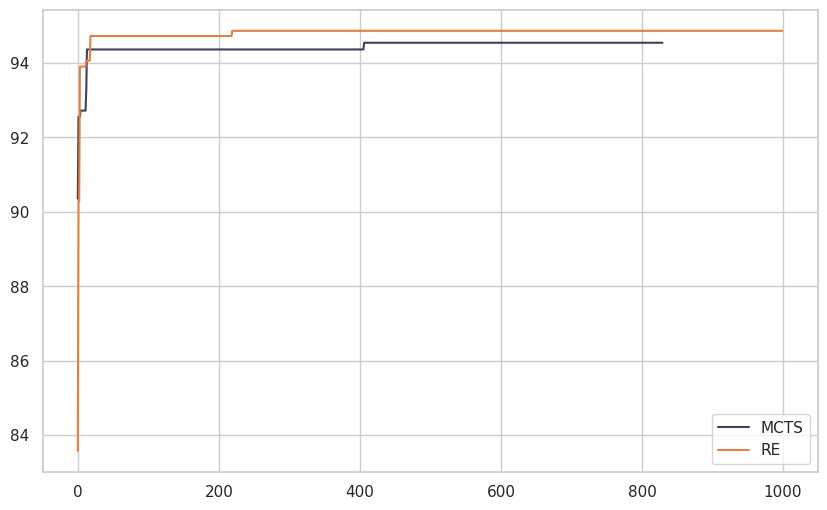

In [34]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.plot(np.array(mcts.best_reward), label="MCTS")
plt.plot(re.best_metric, label="RE")
plt.legend()

## BANANAS

In [38]:
from naslib.optimizers import Bananas

# Run BANANAS
config.search.acq_fn_optimization = "mutation"
config.search.k = 10
config.search.num_init = 10
config.search.num_ensemble = 3
config.search.predictor_type = "bananas"
config.search.acq_fn_type = "its"
config.search.encoding_type = "path"
config.search.num_arches_to_mutate = 1
config.search.max_mutations = 1
config.search.max_candidates = 200
config.search.num_candidates = 50
config.search.epochs = 10
bananas = Bananas(config)
bananas.adapt_search_space(NasBench101SearchSpace())
bananas.dataset_api = api
# Run Bananas
for epoch in tqdm(range(config.search.epochs)):
    bananas.new_epoch(epoch)
final_reward = bananas.get_final_architecture().query(dataset='cifar10', metric=Metric.VAL_ACCURACY, dataset_api=api)

100%|██████████| 10/10 [00:00<00:00, 22.61it/s]


In [41]:
print(bananas.history)

[]


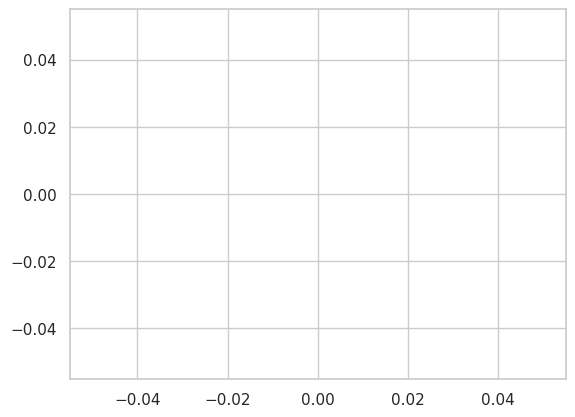

In [40]:
plt.plot(bananas.best_metric)